In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np
from scipy.special import beta as BETA
import time
import math
import torch
from torch.optim.optimizer import Optimizer

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

In [3]:
class IBP:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def rand(self, n, k_max):
        Z = []
        for i in range(n):
            nu = torch.distributions.beta.Beta(self.alpha,1).sample([k_max,1])
            p = self.break_stick_ibp(nu)
            z = torch.distributions.bernoulli.Bernoulli(p).sample().view(1,-1)
            Z.append(z)
        
        Z = torch.cat(Z, 0)
        return Z
    
    def rand_nu(self, nu, n= 1):
        p = self.break_stick_ibp(nu)
        Z = torch.distributions.bernoulli.Bernoulli(p).sample([n])
        return Z
    
    def break_stick_ibp(self, nu):
        K_max = nu.shape[0]
        p = []
        p.append(nu[0,:])
        for k in range(1,K_max):
            p.append(p[k-1]*nu[k,:])
        
        p = torch.cat(p,0)
        return p
        
    def break_log_stick_ibp(self, lognu):
        K_max = nu.shape[0]
        logp = []
        logp.append(lognu[0,:])
        for k in range(1,K_max):
            logp.append(logp[k-1] + lognu[k,:])
        
        logp = torch.cat(logp, 0)
        return logp

In [5]:
class Adam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data#.clamp(-10,10)
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros_like(p.data)
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                val = (grad!=0).float()
                state['step'] += 1# val

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2.pow(0.5)) / bias_correction1

                p.data += -step_size*(exp_avg.div(denom))

        return loss

In [6]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), 'data'))):
    trainset = datasets.MNIST('./data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


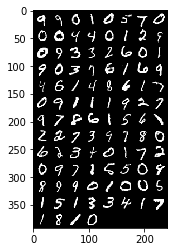

In [8]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [271]:
class stochasticIBP(nn.Module):
    '''
    This is a stochastic IBP layer with unlimited size of input output nodes.
    '''
    def __init__(self, in_features, out_features, bias = True, alpha = 4.0, beta = 1.0, fix = [False, False]):
        super(stochasticIBP, self).__init__()
        '''
        in_features : initial_input_size
        out_features : initial_output_size
        '''
        self.alpha = torch.tensor(alpha)
        self.beta = torch.tensor(beta)
        self.in_features = in_features
        self.out_features = out_features
        self.eps = 10e-10
        
        self.fix_in = fix[0]
        self.fix_out = fix[1]
        
        # Lazy initialization of parameters
        self.weight = nn.Parameter(torch.randn(self.out_features, self.in_features)*self.eps)
        self.weight_std = nn.Parameter(torch.randn(self.out_features, self.in_features)*self.eps)
        if bias:
            self.bias = nn.Parameter(torch.randn(self.out_features, 1)*self.eps)
            self.bias_std = nn.Parameter(torch.randn(self.out_features, 1)*self.eps)
        else:
            self.bias = torch.randn(self.out_features, 1)*0
            self.bias_std = torch.randn(self.out_features, 1)*0
            
        
        self.beta_a = nn.Parameter(torch.zeros(self.out_features, 1) 
                                 + self.inv_softplus(self.alpha) + 
                                 torch.rand(self.out_features,1)*self.eps)
        self.beta_b = nn.Parameter(torch.zeros(self.out_features, 1) 
                                 + self.inv_softplus(torch.tensor(self.beta)) + 
                                 torch.rand(self.out_features,1)*self.eps)
        
        
        # Gumbel Bernoulli
        self.phi = nn.Parameter(torch.randn(self.in_features,self.out_features)*self.eps)
        self.bias_phi = nn.Parameter(torch.randn(self.out_features, 1)*self.eps)
        self.temperature = torch.zeros(self.out_features, 1) + 10
        self.t_prior = 0.1 # prior temperature
        
        # RRS
        self.rhos = torch.zeros(self.out_features + 1,1) + 0.5
        self.curr_out = self.out_features
        self.curr_in = self.in_features
        
        
        # To use or not to use
        self.store_KL = False
        self.KLs = None
        self.code = None
        
    def inv_softplus(self, alpha):
        with torch.no_grad():
            mask = (alpha <= 20).float()
            
        ret = alpha*(1-mask) + torch.log(torch.exp(alpha) - 1)*mask
        return ret
        
    def softplus(self, x):
        with torch.no_grad():
            mask = (x <= 20).float()
        ret = x*(1-mask) + torch.log(torch.exp(x) + 1)*mask
        return ret
    
    def forward(self, input, k = 0, sample_size = 1):
        ################## this the layers functional part
        if(self.code is not None):
            return self.code[:self.curr_out,:]
        
        
        x = input
        N, D = x.shape
        
        if(D > self.curr_in):
            self.update_layer(D, self.out_features)
        
        if(k == 0):
            k = self.curr_out
        
        
        mu = F.linear(x, self.weight[:k,:D]) + self.bias[:k,:].view(-1,k) # N x k
        if(self.fix_out):
            return mu
        
        log_var = F.linear(x, self.weight_std[:k,:D]) + self.bias_std[:k,:].view(-1,k) # N x k
        
        ################## Gaussian reparameterization...............
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s)
        z_gauss = eps.mul(s).add_(mu)
        
        inter_z = torch.mm(x, self.phi[:D,:k]) + self.bias_phi[:k,:].view(-1,k) # N x k
    
        ################## Reparameterized gumbel kumaraswamy part........
        G1 = torch.distributions.uniform.Uniform(self.eps, 
                                1-self.eps).sample([N,k,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
            
        ## Sampling the Nu's with stick breaking IBP
        a = self.softplus(self.beta_a[:k,:]).view(k,1)
        b = self.softplus(self.beta_b[:k,:]).view(k,1)
        U = torch.distributions.uniform.Uniform(self.eps, 
                                1-self.eps).sample([k,sample_size])
        nu = (1-(U+self.eps).pow(1/a) + self.eps).pow(1/b).view(1,-1, sample_size)[0]
        
        K_max = nu.shape[0]
        p = []
        p.append(nu[0,:])
        for t in range(1,K_max):
            p.append(p[t-1]*nu[t,:])
        p = torch.cat(p,0)
        
        pi = torch.distributions.bernoulli.Bernoulli(p).sample([N]).view(N,-1, sample_size)
        logit_pi = ((pi + self.eps)/(1-pi + self.eps)).log()
        
        logit_alpha = logit_pi + inter_z.view(N,k,1)
        alpha = logit_alpha.sigmoid()
        
        z1 = (logit_alpha + logit_G1)/self.temperature[:k,:].view(1,k,1)
        z = z1.sigmoid()
        
        code = z_gauss*z.mean(dim=-1).view(N,k) # N x k   : this will the output of the network.....
        
        if(not self.store_KL):    
            return code 
        
        ################################################################################
        
        #        This layer code is written by "Abhishek Kumar" github : scakc         #
        
        ################################################################################
        ####### Calculation of KL divergence for this layer with priors.....
        curr_K = self.curr_out
        eps = self.eps
        
        
        # KL Gauss
        KL_gauss = (-0.5*(1 + log_var - mu.pow(2) - log_var.exp()).view(N,curr_K).mean(dim = 0).view(1,-1))
        KL_gauss[KL_gauss != KL_gauss] = 0
        KL_gauss = KL_gauss.view(curr_K, 1)# curr_K x 1
        
        
        # KL Kumaraswamy 
        a = self.softplus(self.beta_a[:curr_K,:]).view(curr_K,1)
        b = self.softplus(self.beta_b[:curr_K,:]).view(curr_K,1)
        euler_constant = -torch.digamma(torch.tensor(1.0))
        KL_kuma = ((a - self.alpha)/(a))*(-euler_constant -torch.digamma(b) - 1/b)
        KL_kuma += (a.log() + b.log()) + torch.log(torch.tensor(BETA(model.alpha,1)))
        KL_kuma -= (b - 1)/(b) 
        KL_kuma[KL_kuma != KL_kuma] = 0 
        KL_kuma = KL_kuma.view(curr_K,1)  # curr_K x 1
        
        
        # KL Gumbel 
        logit_pi = (pi+eps).log() - (1-pi+eps).log()
        logit_x  =  (z+eps).log() - (1 -z+eps).log()
        logit_gi = (alpha+eps).log() - (1-alpha+eps).log()
        
        tau = model.temperature[:curr_K,:].view(1,curr_K,1)
        tau_prior = model.t_prior
        
        exp_term_p = logit_pi - logit_x*(tau)
        exp_term_q = logit_gi - logit_x*(tau)
        log_tau = torch.log(torch.tensor(tau, requires_grad = False))
        log_taup = torch.log(torch.tensor(tau_prior, requires_grad = False))
        
        softplus = torch.nn.Softplus(threshold = 20)
        log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
        log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)
        KL_gumb = (log_qz - log_pz)
        KL_gumb[KL_gumb != KL_gumb] = 0
        KL_gumb = KL_gumb.mean(dim =-1).mean(dim = 0).view(curr_K,1) # curr_K x 1
        
        self.KLs = [KL_gauss, KL_kuma, KL_gumb]
        self.code = code
        
        
        return code
    
    
    def update_layer(self, in_features, out_features):
        
        if(out_features > self.out_features):
            k = out_features - self.out_features
            with torch.no_grad():
                self.beta_a = nn.Parameter(torch.cat((self.beta_a, torch.rand(k,1)*self.eps + self.softplus(self.alpha)), 0))
                self.beta_b = nn.Parameter(torch.cat((self.beta_b, torch.rand(k,1)*self.eps + self.softplus(self.beta)), 0))

                self.phi = nn.Parameter(torch.cat((self.phi, torch.randn(self.in_features,k)), 1))
                self.weight = nn.Parameter(torch.cat((self.weight, torch.randn(k, self.in_features)), 0)*self.eps)
                self.weight_std = nn.Parameter(torch.cat((self.weight_std, torch.randn(k, self.in_features)), 0)*self.eps)
                self.bias = nn.Parameter(torch.cat((self.bias, torch.randn(k, 1)), 0)*self.eps)
                self.bias_std = nn.Parameter(torch.cat((self.bias_std, torch.randn(k, 1)), 0)*self.eps)
                self.bias_phi = nn.Parameter(torch.cat((self.bias_phi, torch.randn(k, 1)), 0)*self.eps)
                self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
                self.temperature = torch.cat((self.temperature, torch.zeros(k,1) + 10.0), 0)
                
                self.out_features = out_features
                self.curr_out = out_features
        else:
            self.curr_out = out_features
            
        if(in_features > self.in_features):
            k = in_features - self.in_features
            with torch.no_grad():
                self.phi = nn.Parameter(torch.cat((self.phi, torch.randn(k,self.out_features)), 0))
                self.weight = nn.Parameter(torch.cat((self.weight, torch.randn(self.out_features, k)), 1)*self.eps)
                self.weight_std = nn.Parameter(torch.cat((self.weight_std, torch.randn(self.out_features, k)), 1)*self.eps)

                self.in_features = in_features
    
    def constraint_proj(self):
        with torch.no_grad():
            self.beta_a[self.beta_a < 0.1] = 0.1
            self.beta_b[self.beta_b < 0.1] = 0.1
            self.rhos[self.rhos < 10e-6] = 10e-6
            self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6
            pass

In [272]:
class APIC(nn.Module):
    def __init__(self, latent_variable_dim , rholr = 10e-12, lr = 0.01):
        super(APIC, self).__init__()
       
        # Encoder
        self.D = 784
        self.h_dim = 400
        self.fc1 = nn.Linear(self.D,self.h_dim,True)
        self.sl1 = stochasticIBP(self.h_dim, latent_variable_dim)
        self.sl2 = stochasticIBP(latent_variable_dim, self.h_dim, fix = [False, True])
        self.fc2 = nn.Linear(self.h_dim, self.D,True)
        
        self.sls = [self.sl1]
        
        self.optimizer = None
        self.lr = lr
        self.rholr = rholr
    def forward(self, input):
        x = input.view(-1, self.D)
        x = F.relu(self.fc1(x))
        x = self.sl1(x)
        x = F.relu(self.sl2(x))
        x = self.fc2(x).sigmoid()
        return x
    
    def train_layer(self, layer, images):
        # if its not a stochastic layer with fixout as False then normal flow else
        
        
        self.optimizer.zero_grad()
        curr_K = layer.curr_out
        layer.rhos[0] == 1
        with torch.no_grad():
            rhos = list(model.rhos)[:curr_K+1]
            L = len(rhos)
            samples = []
            for i in range(sample_max):
                k = 1
                while(True):
                    u = np.random.uniform()
                    if(u > rhos[k]):
                        samples.append(k)
                        break
                    k += 1
                    if(k > L-1 and sample):
                        rhos.append(0.5)
                        L = len(rhos)
                    elif(k > L-1):
                        break
        samples.sort()
        new_value = int(np.max(samples[-5:]))
        layer.update_layer(layer.in_features, new_value)
        self.dynamize_Adam()
        
        
        curr_K = layer.curr_out
        with torch.no_grad():
            while(len(rhos)<curr_K+1):
                rhos.append(0.5)
            omrho = 1 - np.array(rhos)[:curr_K+1]
            weight = omrho*0
            for i in range(len(samples)):
                val = samples[i]+1
                weight[:val] += omrho[:val]
            weight/=len(samples)
            weightf = torch.tensor(weight).view(1,-1).float()
        
        model.optimizer.zero_grad()
        one_minus_rho = weightf[:,:curr_K+1]
        
        l = torch.zeros(curr_K+1,1)
        one_minus_rho = one_minus_rho.view(-1,1)
        weight = torch.zeros_like(one_minus_rho)
        weight[curr_K] = one_minus_rho[curr_K]
        for i in range(1,curr_K+1):
            weight[curr_K-i] = weight[curr_K-i+1] + one_minus_rho[curr_K - i]
        
        N = images.shape[0]
        global_multiplier = (N/60000)*1000
        
        
        
        layer.store_KL = True
        _ = self.forward(images)
        KL_gauss, KL_kuma, KL_gumb = layer.KLs
        layer.KLs = None
        layer.store_KL = False
        
        l[1:,:] += KL_gauss[:,:curr_K] + KL_kuma[:,:curr_K] + KL_gumb[:,:curr_K]
        
        
        #likelihood
        lik_loss = 0
        for i in range(1,curr_K+1):
            sigma2X = 0.01
            layer.curr_out = i
            recon_image = model(images)
            logity = ((recon_image + eps).log() - (1 - recon_image + eps).log()).view(-1,model.D)
            Lik = images.view(-1,model.D)*logity - softplus(logity)
            Lik = torch.sum(Lik)/(N)

            lik_loss += Lik*one_minus_rho[i]
            l[i,:] -= Lik
        
        layer.code = None
        
        v0 = - lik_loss
        v1 = (KL_gauss*weight.view(-1,1)).sum()
        v2 = (KL_gumb*weight.view(-1,1)).sum()
        v3 = (KL_kuma*global_multiplier*weight.view(-1,1)).sum()
        
        l_final_params = v0+v1+v2+v3
        l_final_params.backward()
        self.optimizer.step()
        layer.constraint_proj()

        rgg = torch.zeros_like(layer.rhos)
        for ck in samples:
            ckp1 = ck + 1
            rho_grads = [torch.tensor([0])]
            ckp1 = len(rhos)
            rho_rr = list(layer.rhos)[:ckp1]
            l_rr = l[1:ckp1]


            for k in range(1,ckp1):

                grad = 0.0

                if(k >= l.shape[0]):
                    rho_grads.append(rho_grads[0])
                    continue
                else:
                    for i in range(k-1, l_rr.shape[0]):
                        wi = 0
                        if(k-1 == i):
                            wi = 1/(rho_rr[k-1] - 1)
                        else:
                            wi = 1/rho_rr[k-1]

                        grad += (1-rho_rr[i+1])*wi*l_rr[i]

                rho_grads.append(grad)
            rho_grads = torch.tensor(rho_grads).view(-1,1)
            rgg[:ckp1] += rho_grads

        rgg/=len(samples)
        rho_grads = rgg[:curr_K+1].clamp(-1000,1000)

        rho_grads[rho_grads != rho_grads] = 0.0
        rho_logit = ((layer.rhos).log() - (1 - layer.rhos).log())[:curr_K+1]
        sig_rho = rho_logit.sigmoid()


        rho_logit[:curr_K+1,:] = rho_logit[:curr_K+1,:] - layer.rholr*(sig_rho*(1-sig_rho)*rho_grads.view(-1,1))
        with torch.no_grad():
            layer.rhos[:curr_K+1,:] = (rho_logit).sigmoid()


    
    def dynamize_Adam(self, reset = False, amsgrad = True):
        with torch.no_grad():
            if(reset or self.optimizer == None):
                self.optimizer = Adam(self.parameters(), self.lr, amsgrad = amsgrad)
                self.optimizer.step()
            else:
                optim = self.optimizer
                newoptim = Adam(self.parameters(), self.lr)

                for i in range(len(optim.param_groups)):
                    group_old = optim.param_groups[i]
                    group_new = newoptim.param_groups[i]

                    for j in range(len(group_old['params'])):
                        params_old = group_old['params'][j]
                        params_new = group_new['params'][j]

                        amsgrad = group_old['amsgrad']
                        newoptim.param_groups[i]['amsgrad'] = amsgrad


                        state_old = optim.state[params_old]
                        state_new = newoptim.state[params_new]

                        state_new['step'] = torch.zeros_like(params_new.data)

                        state_new['exp_avg'] = torch.zeros_like(params_new.data)
                        state_new['exp_avg_sq'] = torch.zeros_like(params_new.data)



                        exp_avg = state_new['exp_avg']
                        exp_avg_sq = state_new['exp_avg_sq']
                        max_exp_avg_sq = None
                        if(amsgrad):
                            state_new['max_exp_avg_sq'] = torch.zeros_like(params_new.data)
                            max_exp_avg_sq = state_new['max_exp_avg_sq']
                            
                        if(len(state_old) == 0):
                            pass
                        else:
                            if(len(state_old['exp_avg'].shape)==2):
                                no,do = state_old['exp_avg'].shape
                                exp_avg[:no,:do] = state_old['exp_avg']
                                exp_avg_sq[:no,:do] = state_old['exp_avg_sq']
                                if(max_exp_avg_sq is not None):
                                    max_exp_avg_sq[:no,:do] = state_old['max_exp_avg_sq']
                                state_new['step'][:no,:do] = state_old['step']

                            elif(len(state_old['exp_avg'].shape)==1):
                                no = state_old['exp_avg'].shape[0]
                                exp_avg[:no] = state_old['exp_avg']
                                exp_avg_sq[:no] = state_old['exp_avg_sq']
                                if(max_exp_avg_sq is not None):
                                    max_exp_avg_sq[:no] = state_old['max_exp_avg_sq']
                                state_new['step'][:no] = state_old['step']

                            else:
                                assert 1 == 2 ,'error in dynamic adam'

                        state_new['exp_avg'] = exp_avg
                        state_new['exp_avg_sq'] = exp_avg_sq

                        newoptim.state[params_new] = state_new
                    
                self.optimizer = newoptim

In [273]:
model = APIC(16)
model.dynamize_Adam()

/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
start = time.time()
for epoch in range(500):
    
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        
        recon_image = model(images)
        model.optimizer.zero_grad()
        l = F.binary_cross_entropy(recon_image, images.view(-1, model.D), reduction='mean')
        l.backward()
        model.optimizer.step()
        
        print("Epoch {},  Loss, {}, batch {}".format(epoch+1, l.detach().numpy()/BATCH_SIZE, i))
        clr(wait = True)
        
plt.plot(train_loss)
plt.show()

Epoch 8,  Loss, 0.0013639041781425476, batch 379


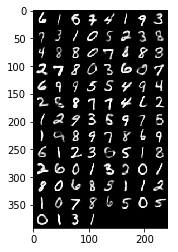

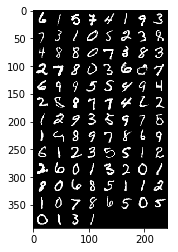

In [256]:
show_images(model(images).view(-1,1,28,28).detach())
plt.show()
show_images(images.detach())

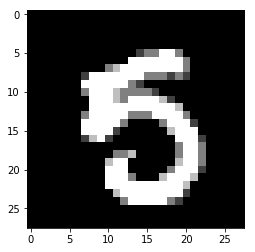

In [254]:
plt.imshow(images[2].detach().view(28,28))

In [264]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.shape)

fc1.weight torch.Size([400, 784])
fc1.bias torch.Size([400])
sl1.weight torch.Size([16, 400])
sl1.weight_std torch.Size([16, 400])
sl1.bias torch.Size([16, 1])
sl1.bias_std torch.Size([16, 1])
sl1.beta_a torch.Size([16, 1])
sl1.beta_b torch.Size([16, 1])
sl1.phi torch.Size([400, 16])
sl1.bias_phi torch.Size([16, 1])
sl2.weight torch.Size([400, 16])
sl2.weight_std torch.Size([400, 16])
sl2.bias torch.Size([400, 1])
sl2.bias_std torch.Size([400, 1])
sl2.beta_a torch.Size([400, 1])
sl2.beta_b torch.Size([400, 1])
sl2.phi torch.Size([16, 400])
sl2.bias_phi torch.Size([400, 1])
fc2.weight torch.Size([784, 400])
fc2.bias torch.Size([784])
